<center><b>In the name of God</b></center>

<b>Course</b>: Machine Learning
<br>
<b>Description:</b> HomeWork 1 | Question 2
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# Libraries

In [2]:
# Import Allowed Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load

In [4]:
# Load Data
data = pd.read_excel("CSM_dataset.xlsx")
# Remove last redundant row
data = data[:-1]

In [8]:
data

,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014.0,6.3,8.0,9130.0,4000000.0,45.0,1.0,0.0,3280543.0,4632.0,425.0,636.0,1120000.0
1,22 Jump Street,2014.0,7.1,1.0,192000000.0,50000000.0,3306.0,2.0,2.0,583289.0,3465.0,61.0,186.0,12350000.0
2,3 Days to Kill,2014.0,6.2,1.0,30700000.0,28000000.0,2872.0,1.0,0.0,304861.0,328.0,34.0,47.0,483000.0
3,300: Rise of an Empire,2014.0,6.3,1.0,106000000.0,110000000.0,3470.0,2.0,0.0,452917.0,2429.0,132.0,590.0,568000.0
4,A Haunted House 2,2014.0,4.7,8.0,17300000.0,3500000.0,2310.0,2.0,0.0,3145573.0,12163.0,610.0,1082.0,1923800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,Child 44,2015.0,6.4,4.0,1210000.0,50000000.0,66.0,1.0,4.0,3701061.0,9325.0,641.0,1859.0,NaN
227,Aloha,2015.0,5.5,15.0,21000000.0,37000000.0,2815.0,1.0,13.0,7119456.0,18803.0,1128.0,2290.0,NaN
228,Unfinished Business,2015.0,5.4,8.0,10200000.0,35000000.0,2777.0,1.0,7.0,3450614.0,6823.0,325.0,409.0,NaN
229,War Room,2015.0,5.4,1.0,12300000.0,3000000.0,NaN,1.0,10.0,66872.0,400.0,67.0,201.0,NaN


In [110]:
data["Gross"].values

array([9.13e+03, 1.92e+08, 3.07e+07, 1.06e+08, 1.73e+07, 2.90e+04,
       4.26e+07, 5.75e+06, 2.60e+07, 4.86e+07, 3.50e+08, 1.52e+07,
       8.43e+07, 8.59e+07, 8.30e+05, 1.18e+04, 7.23e+04, 1.46e+07,
       2.22e+08, 2.16e+07, 4.63e+07, 2.54e+07, 2.03e+07, 1.87e+06,
       9.84e+03, 6.37e+06, 2.60e+08, 2.09e+08, 3.05e+07, 1.58e+07,
       1.51e+08, 4.20e+07, 5.59e+07, 2.88e+07, 8.62e+07, 3.89e+07,
       1.00e+08, 2.34e+07, 8.69e+03, 1.21e+06, 8.57e+07, 1.02e+05,
       6.08e+07, 1.04e+05, 2.01e+08, 1.68e+08, 3.33e+08, 3.01e+04,
       9.14e+07, 7.27e+07, 5.44e+07, 1.77e+08, 5.05e+07, 2.75e+05,
       8.09e+06, 1.88e+08, 4.76e+07, 1.28e+08, 1.47e+07, 5.05e+07,
       4.70e+07, 4.30e+07, 2.45e+06, 1.28e+08, 1.29e+05, 1.40e+07,
       8.24e+07, 8.30e+03, 2.47e+03, 1.27e+08, 2.41e+08, 3.48e+05,
       3.64e+07, 1.04e+07, 1.12e+08, 5.12e+07, 4.01e+06, 4.36e+07,
       1.50e+08, 1.14e+08, 3.23e+07, 5.25e+07, 1.01e+08, 9.14e+07,
       3.57e+04, 5.08e+07, 7.61e+07, 3.25e+07, 8.33e+07, 5.92e

# Handle Null Values

In [10]:
data.isnull().sum()

Movie                   0
Year                    0
Ratings                 0
Genre                   0
Gross                   0
Budget                  1
Screens                10
Sequel                  0
Sentiment               0
Views                   0
Likes                   0
Dislikes                0
Comments                0
Aggregate Followers    35
dtype: int64

In [13]:
data = data.fillna(data.mean())

# Correlation

In [56]:
def correlation(feature1_values, feature2_values):
    """
    Calculate correlation between two features
    
    feature1_values: the list of values for the first feature
    feature2_values: the list of values for the second feature 
    """
    
    faeture1_std = np.std(feature1_values)
    feature2_std = np.std(feature2_values)
    covariance = np.cov(feature1_values, feature2_values)[1,0]
    return float("{:.2f}".format(covariance/(faeture1_std*feature2_std)))
    

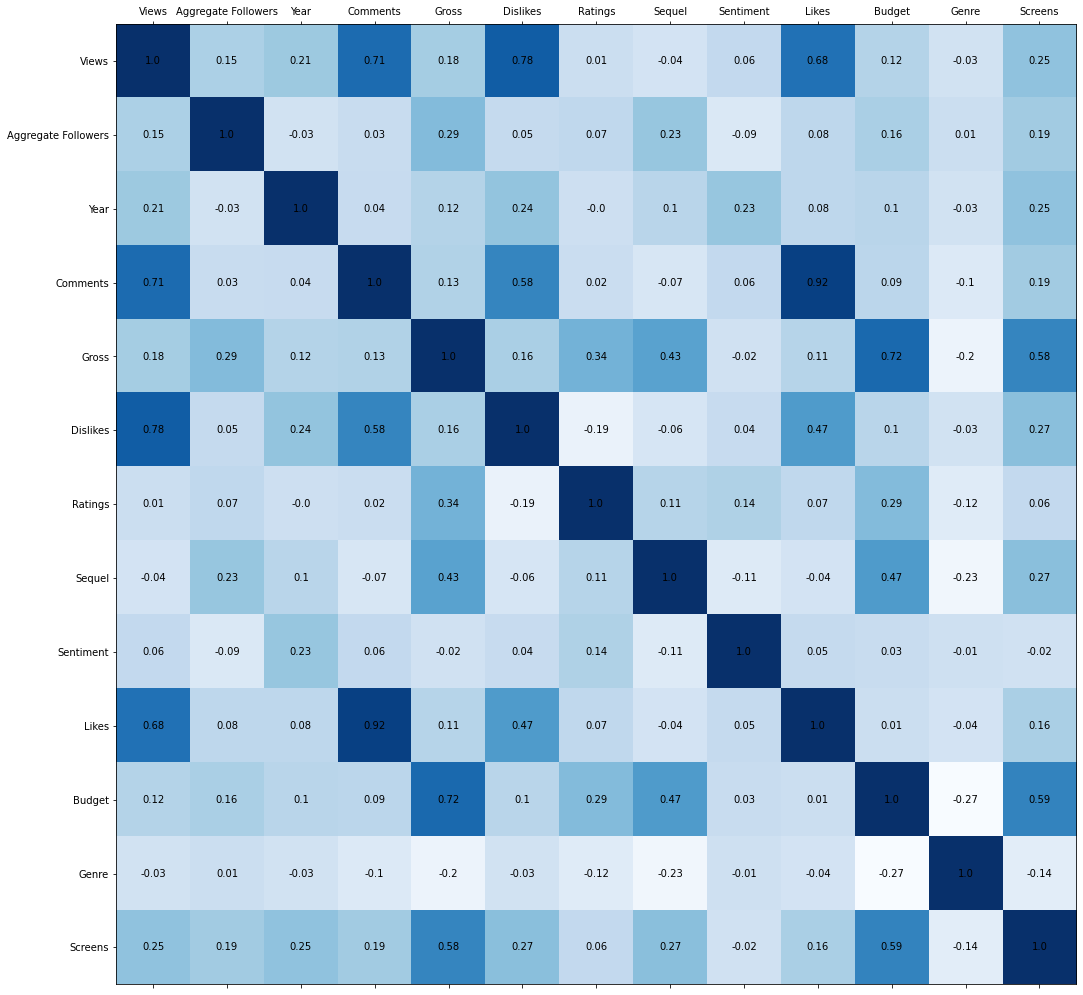

In [105]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

correlation_matrix = np.zeros((len(data_columns), len(data_columns)))

for i, column1 in enumerate(data_columns):
    for j, column2 in enumerate(data_columns):
        correlation_matrix[i, j] = correlation(data[column1].values, data[column2].values)
        

ax.matshow(correlation_matrix, cmap=plt.cm.Blues)
# plt.rcParams["figure.autolayout"] = True

for i, column1 in enumerate(data_columns):
    for j, column2 in enumerate(data_columns):
        c = correlation_matrix[j,i]

        ax.text(i, j, str(c), va='center', ha='center')
                
column_labels = data_columns
row_labels = data_columns

ax.set_xticks(np.arange(len(column_labels)))
ax.set_yticks(np.arange(len(column_labels)))

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)        

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()